# Imports

In [106]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import math
from collections import defaultdict
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import pairwise_distances
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score
import random

import warnings
warnings.filterwarnings("ignore")


# Problem 1

In [61]:
# Load the training and test datasets
train_data = pd.read_csv('train.csv').drop('Id', axis=1)
test_data = pd.read_csv('test.csv').drop('Id', axis=1)
y_test = pd.read_csv('salePrice.csv')[['SalePrice']]

# Display the first 5 records from the training dataset
print(train_data.shape)
train_data.head()


(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [62]:
# Define columns to check for outliers
outlier_columns = ['LotFrontage', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'LotArea', 'GrLivArea', 'TotalBsmtSF']

# Initialize an empty dictionary to store the mean and standard deviation of each column
stats = {}

# Calculate mean and standard deviation manually for each column
for col in outlier_columns:
    # Step 1: Calculate the mean
    col_sum = sum(train_data[col])
    col_mean = col_sum / len(train_data[col])

    # Step 2: Calculate the variance (average of squared differences from the mean)
    variance_sum = sum((x - col_mean) ** 2 for x in train_data[col])
    col_std = np.sqrt(variance_sum / len(train_data[col]))

    # Store the calculated mean and std deviation
    stats[col] = {'mean': col_mean, 'std': col_std}

# Calculate Z-scores manually and filter outliers
filtered_rows = []
for index, row in train_data.iterrows():
    outlier = False
    for col in outlier_columns:
        z_score = (row[col] - stats[col]['mean']) / stats[col]['std']
        if abs(z_score) > 3:
            outlier = True
            print(f'a row will be removed with id={index} z_score={z_score} and col={col}')
            break
    if not outlier:
        filtered_rows.append(row)

# Create a new DataFrame with filtered rows
train_data_no_outliers = pd.DataFrame(filtered_rows)

# Display result
print("Data after removing outliers:")
train_data_no_outliers.shape


a row will be removed with id=53 z_score=3.9842438435787915 and col=LotArea
a row will be removed with id=118 z_score=3.2486865082985994 and col=GrLivArea
a row will be removed with id=137 z_score=3.033081860040691 and col=BsmtUnfSF
a row will be removed with id=178 z_score=3.2424771855457384 and col=GarageArea
a row will be removed with id=185 z_score=3.9835041568869474 and col=GrLivArea
a row will be removed with id=197 z_score=3.0392825151775673 and col=GrLivArea
a row will be removed with id=224 z_score=4.004295000518198 and col=BsmtUnfSF
a row will be removed with id=249 z_score=14.88128503372421 and col=LotArea
a row will be removed with id=278 z_score=3.5175564802322676 and col=BsmtUnfSF
a row will be removed with id=304 z_score=3.7645818004422322 and col=GrLivArea
a row will be removed with id=313 z_score=20.518273157773258 and col=LotArea
a row will be removed with id=332 z_score=4.899203675328677 and col=TotalBsmtSF
a row will be removed with id=335 z_score=15.448541728223589

(1412, 80)

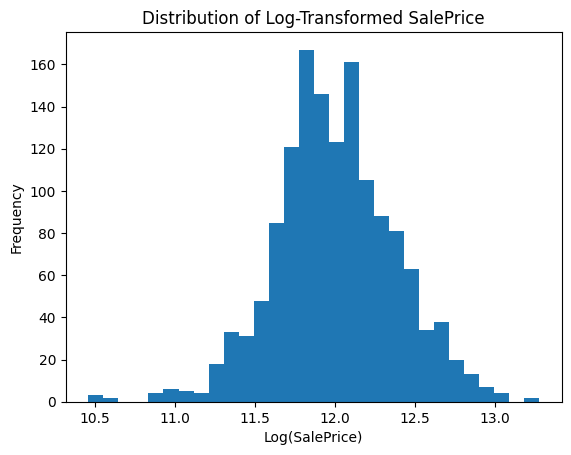

In [63]:
# Apply log1p manually to the 'SalePrice' column in train_data_no_outliers
sale_price_log = []
for price in train_data_no_outliers['SalePrice']:
    sale_price_log.append(math.log(1 + price))

# Update the 'SalePrice' column with the transformed values
train_data_no_outliers['SalePrice'] = sale_price_log

# Visualize to confirm normalization if desired
plt.hist(train_data_no_outliers['SalePrice'], bins=30)
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Frequency")
plt.show()

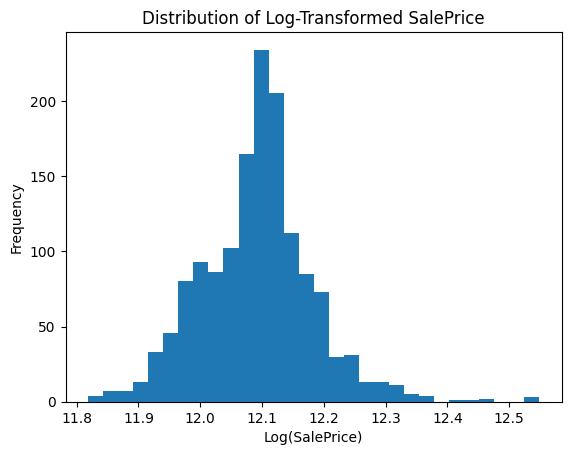

In [64]:
# Apply log1p manually to the 'SalePrice' column in y_test
sale_price_log = []
for price in y_test['SalePrice']:
    sale_price_log.append(math.log(1 + price))

# Update the 'SalePrice' column with the transformed values
y_test['SalePrice'] = sale_price_log
# Visualize to confirm normalization if desired
plt.hist(y_test, bins=30)
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Frequency")
plt.show()

In [69]:
# Calculate correlation on the original DataFrame (before any transformations)
numerical_cols = train_data_no_outliers.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_data_no_outliers[numerical_cols].corr()

# Show features most correlated with 'SalePrice'
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(15)
print(top_corr_features)


In [65]:
train_data_no_outliers.drop(['TotRmsAbvGrd', 'Fireplaces',
                'MasVnrArea', 'BsmtFinSF1'], axis=1, inplace=True)

test_data.drop(['TotRmsAbvGrd', 'Fireplaces',
                'MasVnrArea', 'BsmtFinSF1'], axis=1, inplace=True)

In [ ]:
# train_data_no_outliers['GrLivArea'] = np.log1p(train_data_no_outliers['GrLivArea'])
# train_data_no_outliers['TotalBsmtSF'] = np.log1p(train_data_no_outliers['TotalBsmtSF'])
# train_data_no_outliers['GarageArea'] = np.log1p(train_data_no_outliers['GarageArea'])
# train_data_no_outliers['GrLivArea'] = np.log1p(train_data_no_outliers['GrLivArea'])
# train_data_no_outliers['TotalBsmtSF'] = np.log1p(train_data_no_outliers['TotalBsmtSF'])
# train_data_no_outliers['GarageArea'] = np.log1p(train_data_no_outliers['GarageArea'])


In [66]:
# Separate features and target
X_train = train_data_no_outliers.drop('SalePrice', axis=1)
y_train = train_data_no_outliers['SalePrice']

# Selected features for polynomial transformation
selected_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'YearBuilt',
    'TotalBsmtSF', 'FullBath', '1stFlrSF', 'YearRemodAdd', 'GarageYrBlt'
]

# Step 1: Impute missing values in the selected features
imputer = SimpleImputer(strategy='mean')  # or another strategy based on your data
X_train_imputed = imputer.fit_transform(X_train[selected_features])
X_test_imputed = imputer.transform(test_data[selected_features])

# Step 2: Apply polynomial features after imputation
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_transformer.fit_transform(X_train_imputed)
X_test_poly = poly_transformer.transform(X_test_imputed)

# Step 3: Convert polynomial features to DataFrames
poly_feature_names = poly_transformer.get_feature_names_out(selected_features)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train.index)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=test_data.index)

# Step 4: Combine with original non-selected features (if any)
X_train_combined = X_train.drop(columns=selected_features).join(X_train_poly)
X_test_combined = test_data.drop(columns=selected_features).join(X_test_poly)

# X_train_combined and X_test_combined now have imputed and transformed polynomial features


In [93]:

selector = VarianceThreshold(threshold=0.01)
X_train_combined[numerical_cols] = selector.fit_transform(X_train_combined[numerical_cols])
X_test_combined[numerical_cols] = selector.transform(X_test_combined[numerical_cols])


In [94]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_combined[numerical_cols])
X_test_imputed = imputer.transform(X_test_combined[numerical_cols])

# Standardize numerical columns before applying PCA (PCA requires scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

pca = PCA(n_components=5)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert PCA results to DataFrames with appropriate column names
pca_columns = [f'PCA_{i+1}' for i in range(5)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train_combined.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test_combined.index)

# Remove original numerical columns and add PCA components
X_train_combined = X_train_combined.drop(columns=numerical_cols).join(X_train_pca_df)
X_test_combined = X_test_combined.drop(columns=numerical_cols).join(X_test_pca_df)

In [95]:
# Preprocessing steps for categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform train data
X_train_prepared = preprocessor.fit_transform(X_train_combined)
X_test_prepared = preprocessor.transform(X_test_combined)


print(X_train_prepared.shape)
print(X_test_prepared.shape)

(1412, 248)
(1459, 248)


In [99]:
X_train_combined

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,1stFlrSF YearRemodAdd,1stFlrSF GarageYrBlt,YearRemodAdd^2,YearRemodAdd GarageYrBlt,GarageYrBlt^2,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,1714568.0,1714568.0,4012009.0,4012009.0,4012009.0,1.527626,1.415297,-1.742030,-1.241676,0.122479
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,2493712.0,2493712.0,3904576.0,3904576.0,3904576.0,0.011900,-1.196895,0.798986,-0.533193,-1.826733
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,1841840.0,1840920.0,4008004.0,4006002.0,4004001.0,1.972638,1.323520,-1.069940,-0.775336,-0.022501
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,1893170.0,1920078.0,3880900.0,3936060.0,3992004.0,-0.391166,0.889018,0.691648,-0.027576,0.669578
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,2290000.0,2290000.0,4000000.0,4000000.0,4000000.0,4.316618,1.580762,0.350594,-1.246252,0.084586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,1906000.0,1905047.0,4000000.0,3998000.0,3996001.0,1.231716,1.525849,-1.121163,1.094269,-0.755386
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,4121124.0,4100394.0,3952144.0,3932264.0,3912484.0,2.167146,-2.396843,1.574205,-0.961421,1.272929
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,2383128.0,2305908.0,4024036.0,3893646.0,3767481.0,-0.117757,2.400817,1.983892,0.160402,-1.057967
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,2151688.0,2102100.0,3984016.0,3892200.0,3802500.0,-2.400757,-2.517624,0.724650,-3.811021,1.256003


In [97]:
X_test_combined

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,1stFlrSF YearRemodAdd,1stFlrSF GarageYrBlt,YearRemodAdd^2,YearRemodAdd GarageYrBlt,GarageYrBlt^2,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,1757056.0,1.757056e+06,3845521.0,3.845521e+06,3.845521e+06,-2.003060,-1.656005,0.619571,-0.964845,-0.505550
1,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,2602182.0,2.602182e+06,3833764.0,3.833764e+06,3.833764e+06,-1.080664,-0.286233,2.749587,-1.865226,-0.145985
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,1854144.0,1.853216e+06,3992004.0,3.990006e+06,3.988009e+06,1.045146,1.213740,-0.668202,-1.048338,-0.178164
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,1850148.0,1.850148e+06,3992004.0,3.992004e+06,3.992004e+06,1.343905,1.244358,-0.901650,-1.016509,-0.611823
4,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,2549760.0,2.549760e+06,3968064.0,3.968064e+06,3.968064e+06,0.966936,-0.649256,-2.090893,1.371285,0.424836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,1075620.0,1.080082e+06,3880900.0,3.896999e+06,3.913164e+06,-4.199790,2.753436,-2.526643,0.435850,-0.367565
1455,RM,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,...,1075620.0,1.075620e+06,3880900.0,3.880900e+06,3.880900e+06,-3.288979,2.593164,-2.755132,0.248712,0.372705
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,2443104.0,2.399040e+06,3984016.0,3.912160e+06,3.841600e+06,0.790001,-2.112049,3.252512,-2.442506,-0.589634
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,1932240.0,1.918827e+06,3968064.0,3.940518e+06,3.913164e+06,-2.497276,-0.359863,-0.567758,0.633222,-1.290577


In [ ]:
# Define parameter grids
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
kernel_ridge_params = {'alpha': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gbr_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.2]}
elastic_net_params = {'alpha': [0.001, 0.01, 0.1], 'l1_ratio': [0.1, 0.2, 0.5]}

# Initialize models
models = {
    'Lasso': (Lasso(), lasso_params),
    'Elastic Net': (ElasticNet(), elastic_net_params),
    'Kernel Ridge': (KernelRidge(), kernel_ridge_params),
    'Gradient Boosting': (GradientBoostingRegressor(), gbr_params)
}

# Perform Grid Search for each model
best_estimators = {}
for model_name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train_prepared, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"{model_name} Best Params: {grid_search.best_params_}")


Lasso Best Params: {'alpha': 0.01}
Elastic Net Best Params: {'alpha': 0.001, 'l1_ratio': 0.2}
Kernel Ridge Best Params: {'alpha': 0.1, 'kernel': 'rbf'}
Gradient Boosting Best Params: {'learning_rate': 0.2, 'n_estimators': 200}


Brief Explanation of Learning Rate’s Impact on Model Performance
The learning rate in Gradient Boosting determines the magnitude of corrections applied by each tree. Here’s how it impacts model performance:

Small Learning Rate: A lower learning rate makes the model converge more slowly, as each tree’s predictions are added cautiously to the ensemble. This can help avoid overshooting the minimum error and can lead to more accurate results, but it requires a higher number of trees (iterations) to reach optimal performance.

Large Learning Rate: A higher learning rate speeds up the training process by allowing each tree to make larger adjustments to predictions. However, this can lead to overfitting, as the model might "jump over" the optimal solution, especially when the learning rate is excessively high.

By tuning the learning rate, we balance training efficiency with accuracy, aiming for an optimal combination of model speed and precision.

In [ ]:
# Define MSE and R² manually
def mean_squared_error(y_test, y_pred):
    result = 0
    for i in range(len(y_test)):
        result += (y_test[i] - y_pred[i]) ** 2
    return result / len(y_test)

def r2_score(y_true, y_pred):
    # Step 1: Calculate the mean of y_true
    mean_y = np.mean(y_true)

    # Step 2: Calculate the total sum of squares (ss_total)
    ss_total = 0
    for i in range(len(y_true)):
        ss_total += (y_true[i] - mean_y) ** 2

    # Step 3: Calculate the residual sum of squares (ss_residual)
    ss_residual = 0
    for i in range(len(y_true)):
        ss_residual += (y_true[i] - y_pred[i]) ** 2

    # Step 4: Calculate R²
    return 1 - (ss_residual / ss_total)


# Iterate over best estimators and evaluate
for model_name, model in best_estimators.items():
    predictions = model.predict(X_test_prepared)
    mse = mean_squared_error(y_test.to_numpy(), predictions)
    r2 = r2_score(y_test.to_numpy(), predictions)
    print(f"{model_name} - MSE: {mse}, R²: {r2}")


Lasso - MSE: [0.08334959], R²: [-9.28515629]
Elastic Net - MSE: [0.13995595], R²: [-16.27025697]
Kernel Ridge - MSE: [0.13020875], R²: [-15.0674742]
Gradient Boosting - MSE: [0.14184709], R²: [-16.50362016]


Step 7: Explanation of Model Stacking
Model Stacking is an ensemble learning technique where multiple models are trained on the same dataset, and their predictions are combined by another model (the "meta-model"). The meta-model learns from the outputs of base models, often improving the overall prediction accuracy by leveraging the strengths of different models. In Stacked Regression, each base model’s output serves as input to the meta-model, typically a linear model that learns the best way to combine these predictions.

In [ ]:
# Define base models for stacking
base_models = [
    ('lasso', best_estimators['Lasso']),
    ('elastic_net', best_estimators['Elastic Net']),
    ('kernel_ridge', best_estimators['Kernel Ridge']),
    ('gradient_boosting', best_estimators['Gradient Boosting'])
]

# Define the stacking regressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train the stacked model
stacked_model.fit(X_train_prepared, y_train)


StackingRegressor(estimators=[('lasso', Lasso(alpha=0.01)),
                              ('elastic_net',
                               ElasticNet(alpha=0.001, l1_ratio=0.2)),
                              ('kernel_ridge',
                               KernelRidge(alpha=0.1, kernel='rbf')),
                              ('gradient_boosting',
                               GradientBoostingRegressor(learning_rate=0.2,
                                                         n_estimators=200))],
                  final_estimator=Ridge())

In [ ]:
# Predict and evaluate on test data
stacked_predictions = stacked_model.predict(X_test_prepared)
stacked_mse = mean_squared_error(y_test.to_numpy(), stacked_predictions)
stacked_r2 = r2_score(y_test.to_numpy(), stacked_predictions)

print(f"Stacked Model - MSE: {stacked_mse}, R²: {stacked_r2}")


Stacked Model - MSE: [0.13706935], R²: [-15.9140571]


# Problem 2

In [100]:
# Load the dataset
df = pd.read_csv("song_sales.csv").iloc[:, 1:]

# Identify feature types based on unique counts
unique_counts = df.nunique()
categorical_features = unique_counts[unique_counts <= 100].index.tolist()
numerical_features = unique_counts[unique_counts > 100].index.tolist()
categorical_features.append(numerical_features.pop(0))

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: ['key', 'audio_mode', 'time_signature', 'song_name']
Numerical features: ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'audio_valence', 'song_sales']


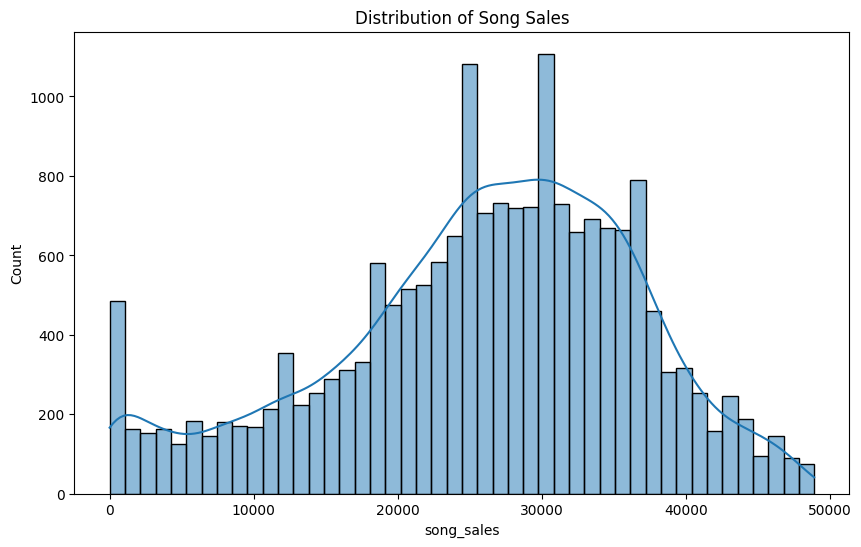

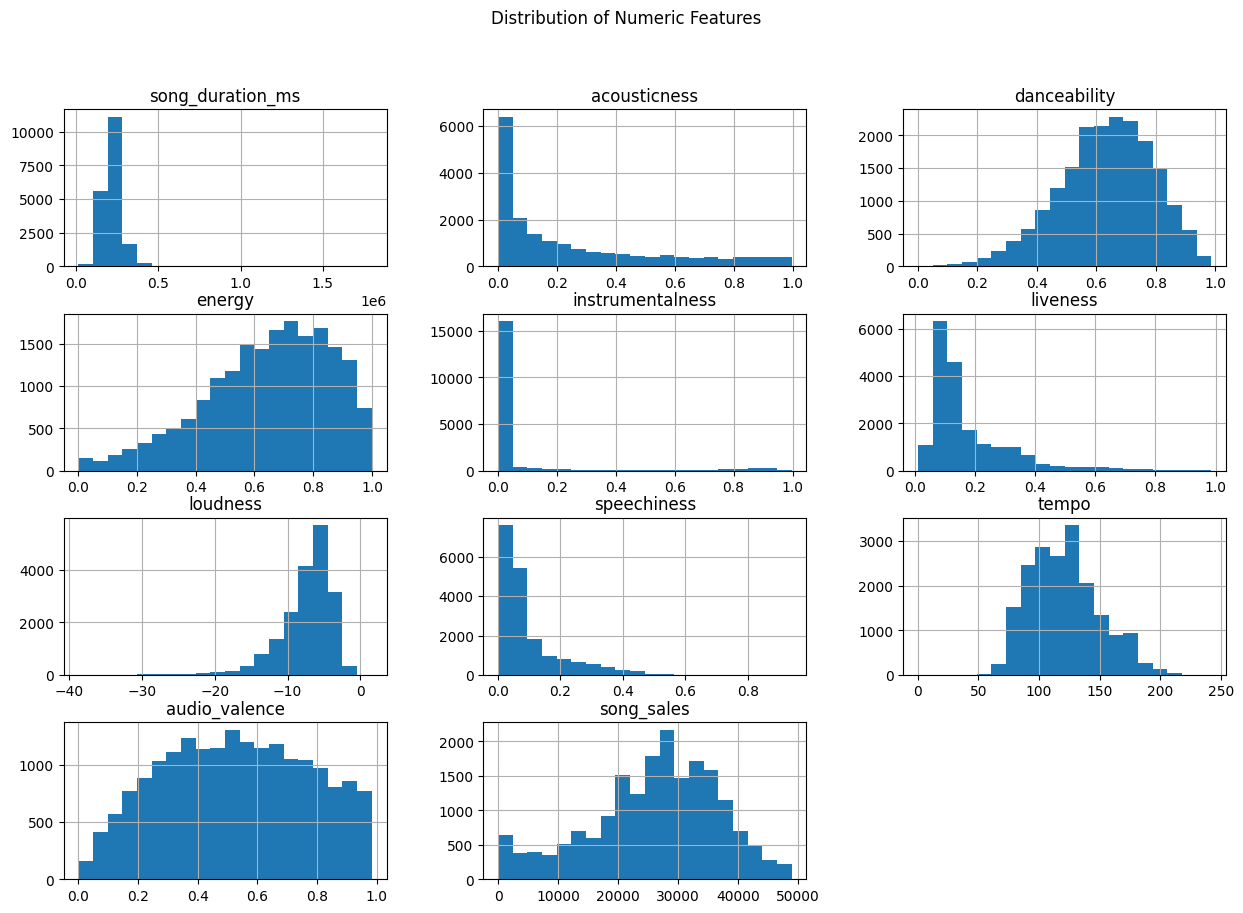

In [101]:

# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['song_sales'], kde=True)
plt.title("Distribution of Song Sales")
plt.show()

# Distribution of numeric features
df[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle("Distribution of Numeric Features")
plt.show()


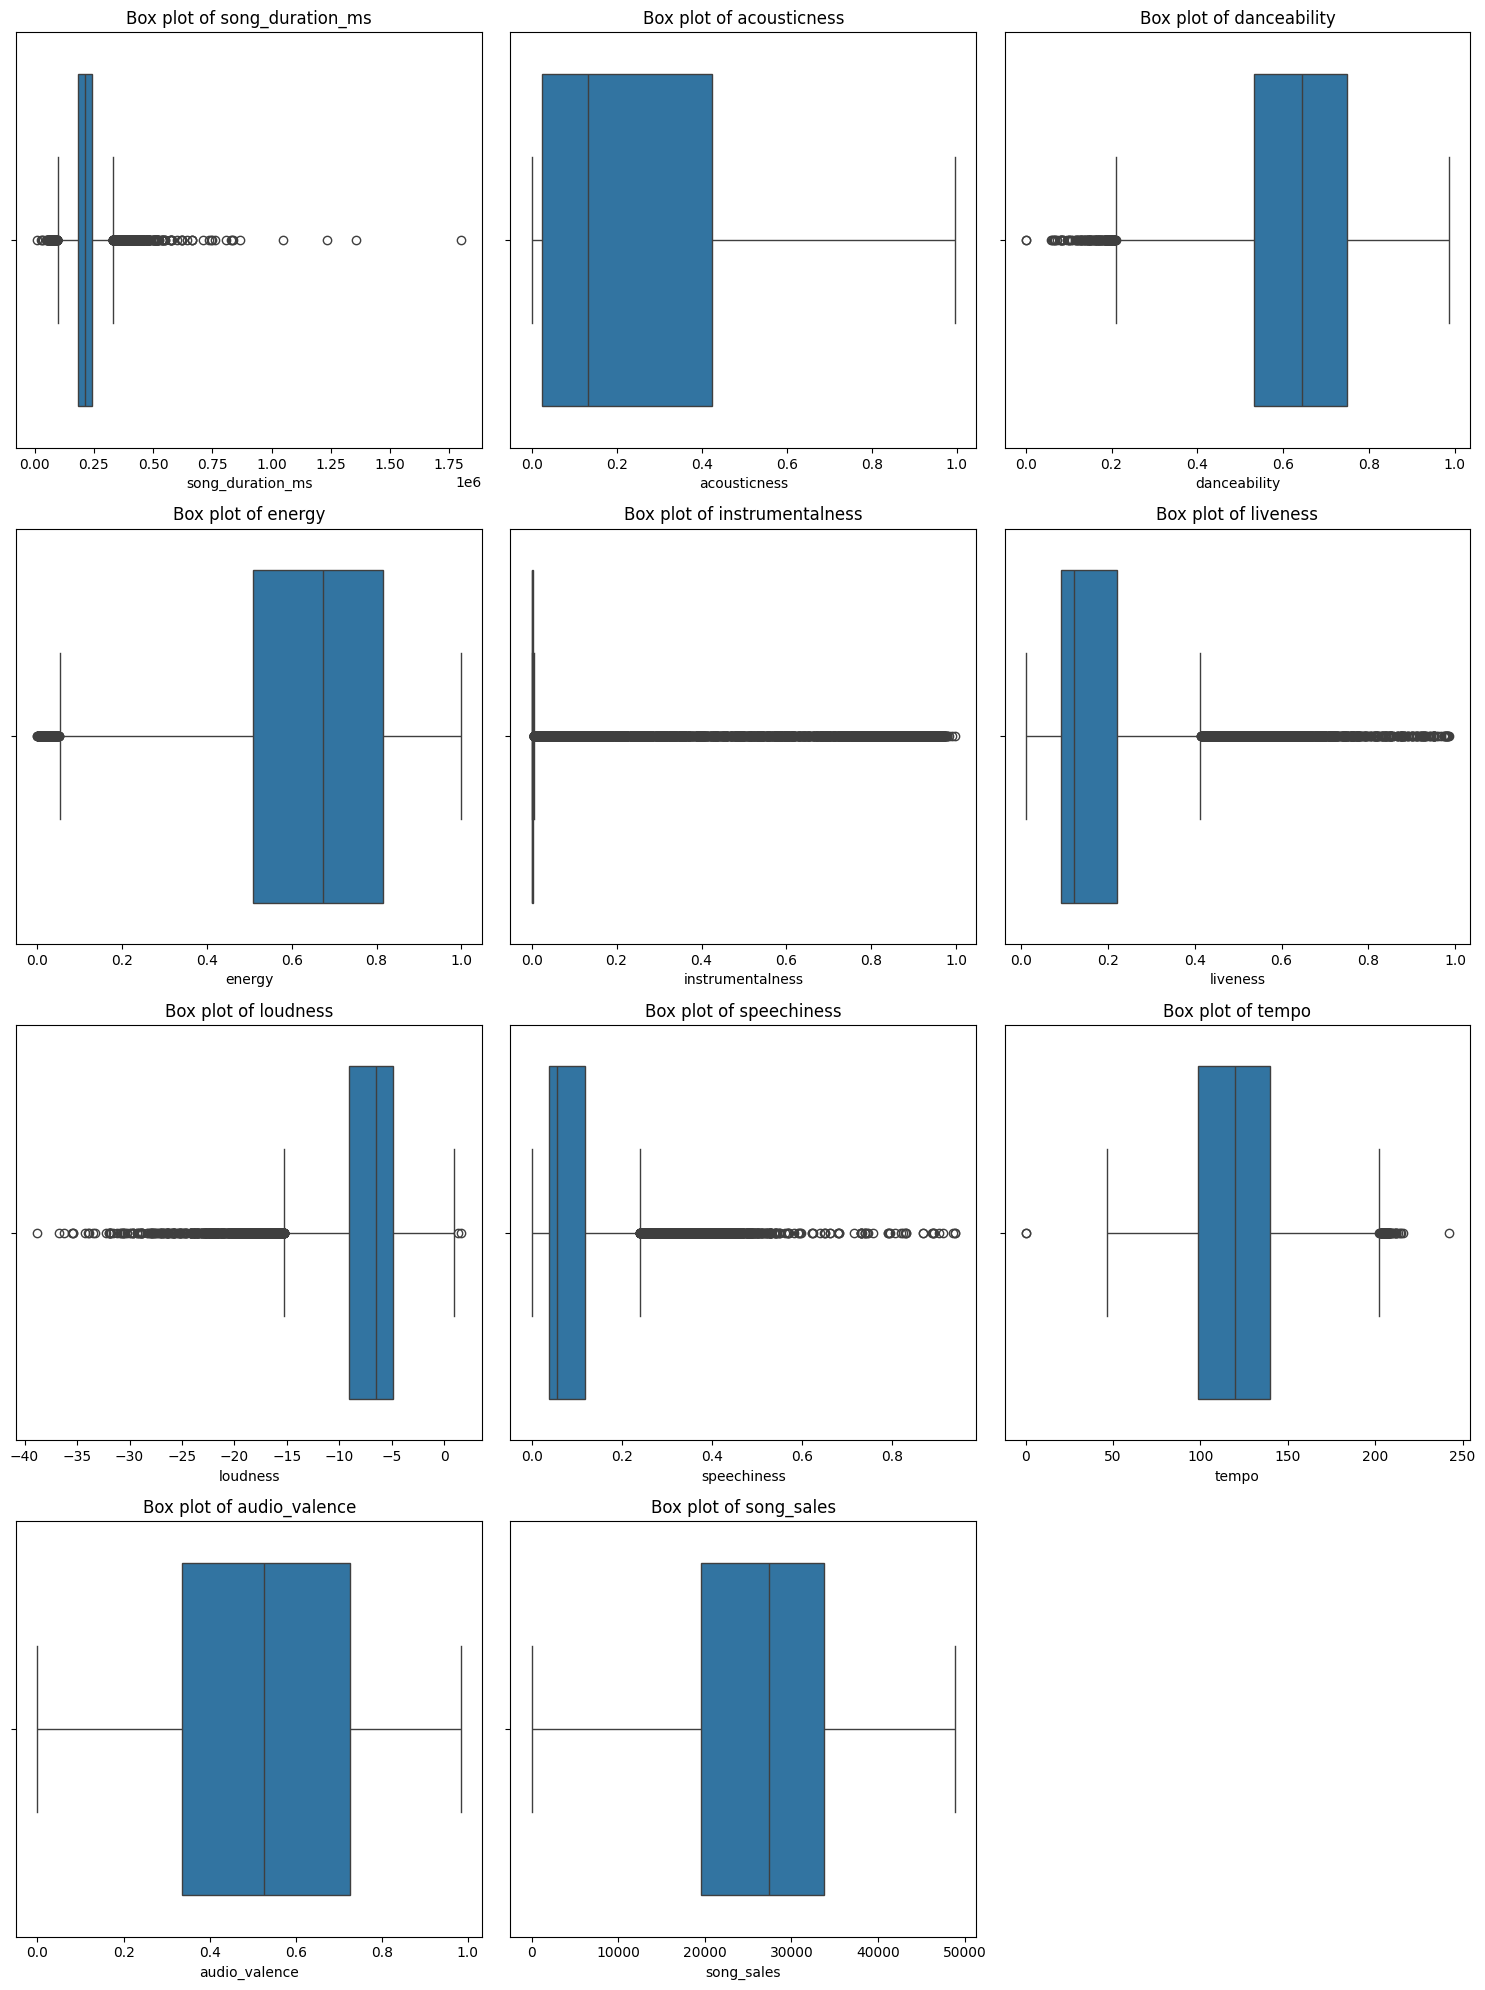

In [102]:
# Determine the number of rows and columns for the subplot grid
num_plots = len(numerical_features)
cols = 3  # Choose the number of columns in the grid
rows = (num_plots // cols) + (1 if num_plots % cols != 0 else 0)

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Plot each boxplot in the corresponding subplot
for i, column in enumerate(numerical_features):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f"Box plot of {column}")

# Hide any extra subplots if there are fewer plots than grid spaces
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to make sure the titles and plots are well spaced
plt.tight_layout()
plt.show()


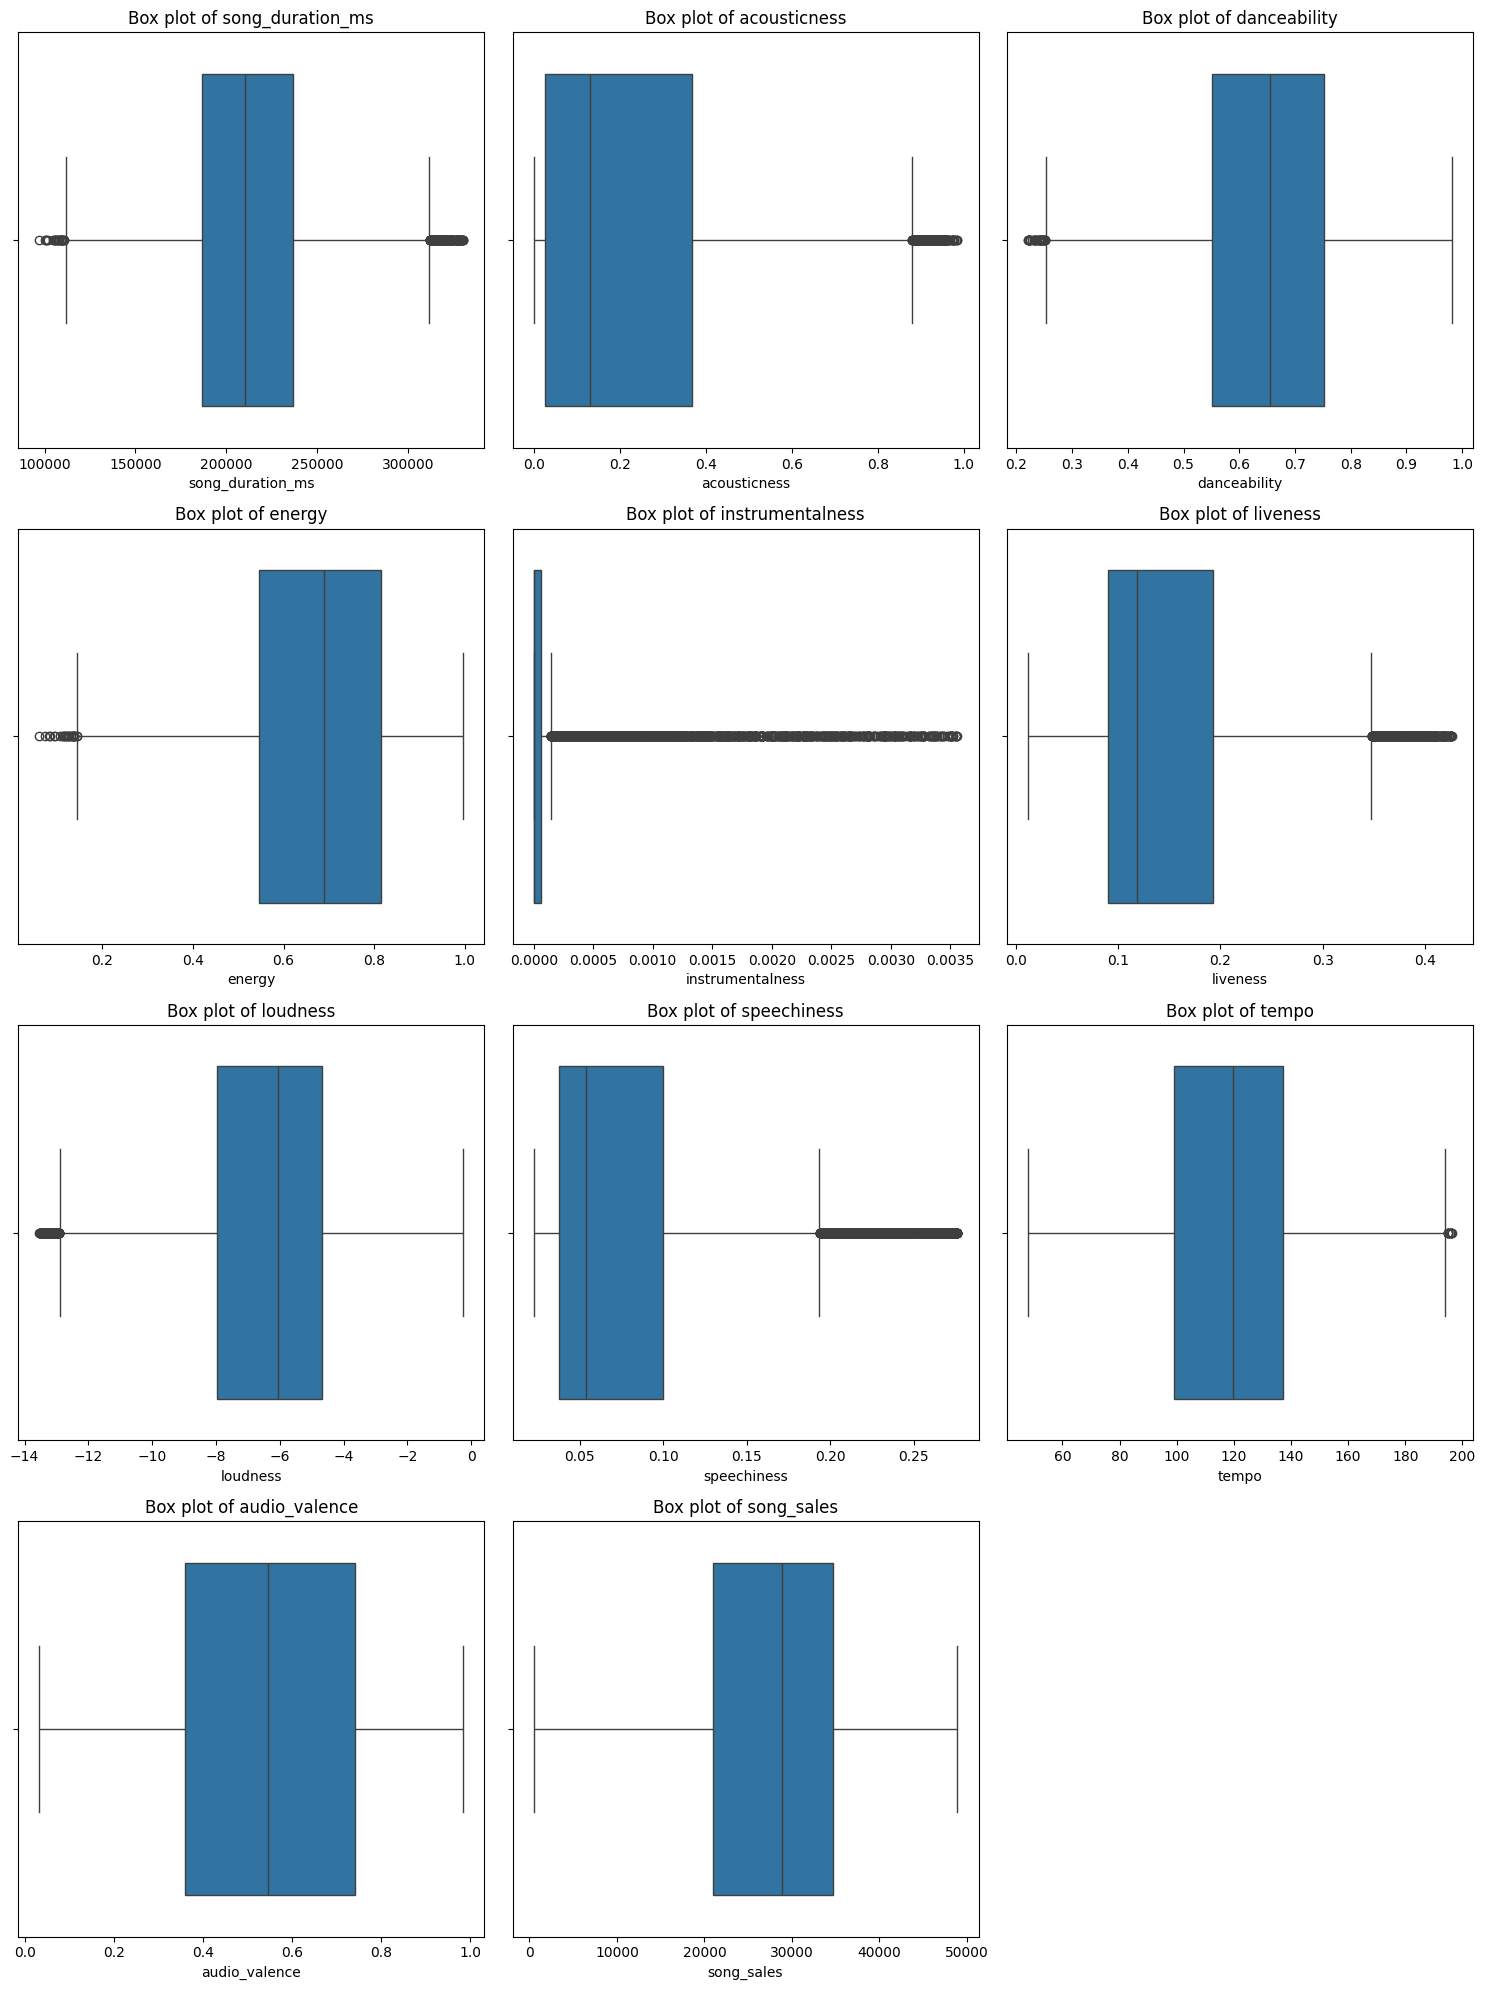

In [103]:


# Drop any rows with NaN values (e.g., from non-numeric data that couldn't be converted)
df = df.dropna()

# Outlier detection and removal function
def remove_outliers(df, column):
    # Sort the column data
    sorted_data = sorted(df[column])
    n = len(sorted_data)

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    # For Q1
    pos_Q1 = 0.25 * (n + 1) - 1  # position in sorted data (zero-indexed)
    lower_idx = int(pos_Q1)  # integer part for position
    upper_idx = lower_idx + 1
    Q1 = (sorted_data[lower_idx] + sorted_data[upper_idx]) / 2 if upper_idx < n else sorted_data[lower_idx]

    # For Q3
    pos_Q3 = 0.75 * (n + 1) - 1  # position in sorted data (zero-indexed)
    lower_idx = int(pos_Q3)  # integer part for position
    upper_idx = lower_idx + 1
    Q3 = (sorted_data[lower_idx] + sorted_data[upper_idx]) / 2 if upper_idx < n else sorted_data[lower_idx]

    # Calculate IQR
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df


# Apply outlier removal only to numerical columns
for column in numerical_features:
    if pd.api.types.is_numeric_dtype(df[column]):
        df = remove_outliers(df, column)
    else:
        print(f"Skipping non-numeric column: {column}")

# Check for remaining outliers visually
# Determine the number of rows and columns for the subplot grid
num_plots = len(numerical_features)
cols = 3  # Choose the number of columns in the grid
rows = (num_plots // cols) + (1 if num_plots % cols != 0 else 0)

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Plot each boxplot in the corresponding subplot
for i, column in enumerate(numerical_features):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(f"Box plot of {column}")

# Hide any extra subplots if there are fewer plots than grid spaces
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to make sure the titles and plots are well spaced
plt.tight_layout()
plt.show()


In [ ]:
numerical_features.remove('instrumentalness')
numerical_features

['song_duration_ms',
 'acousticness',
 'danceability',
 'energy',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'audio_valence',
 'song_sales']

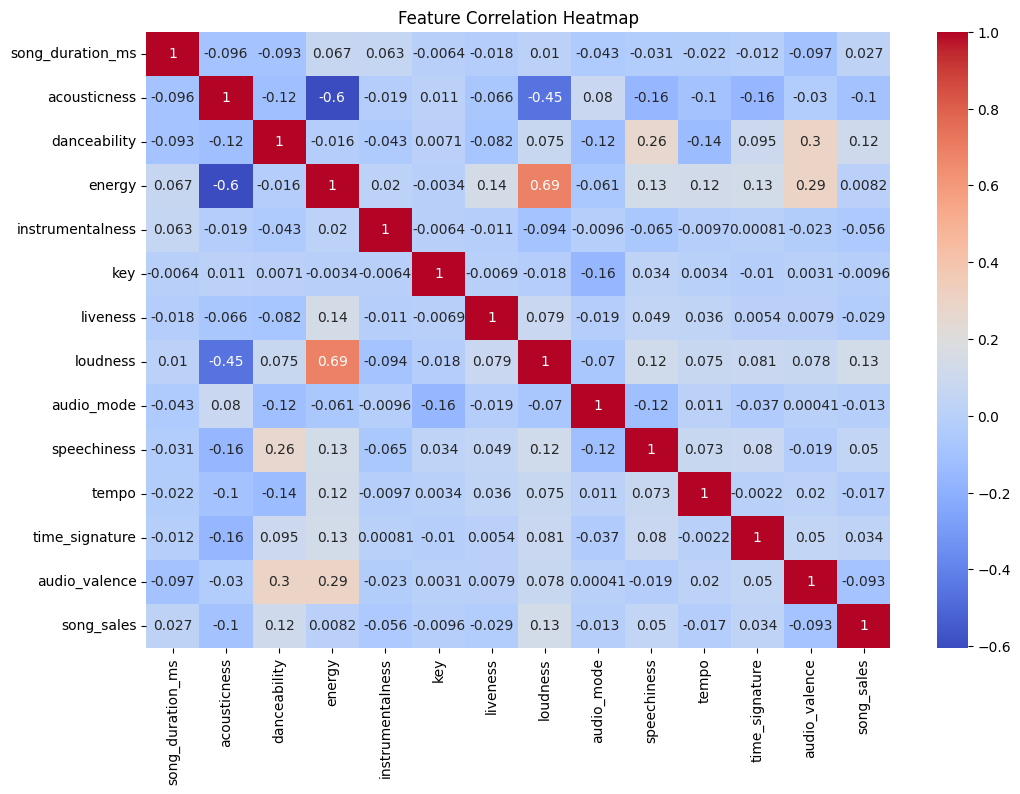

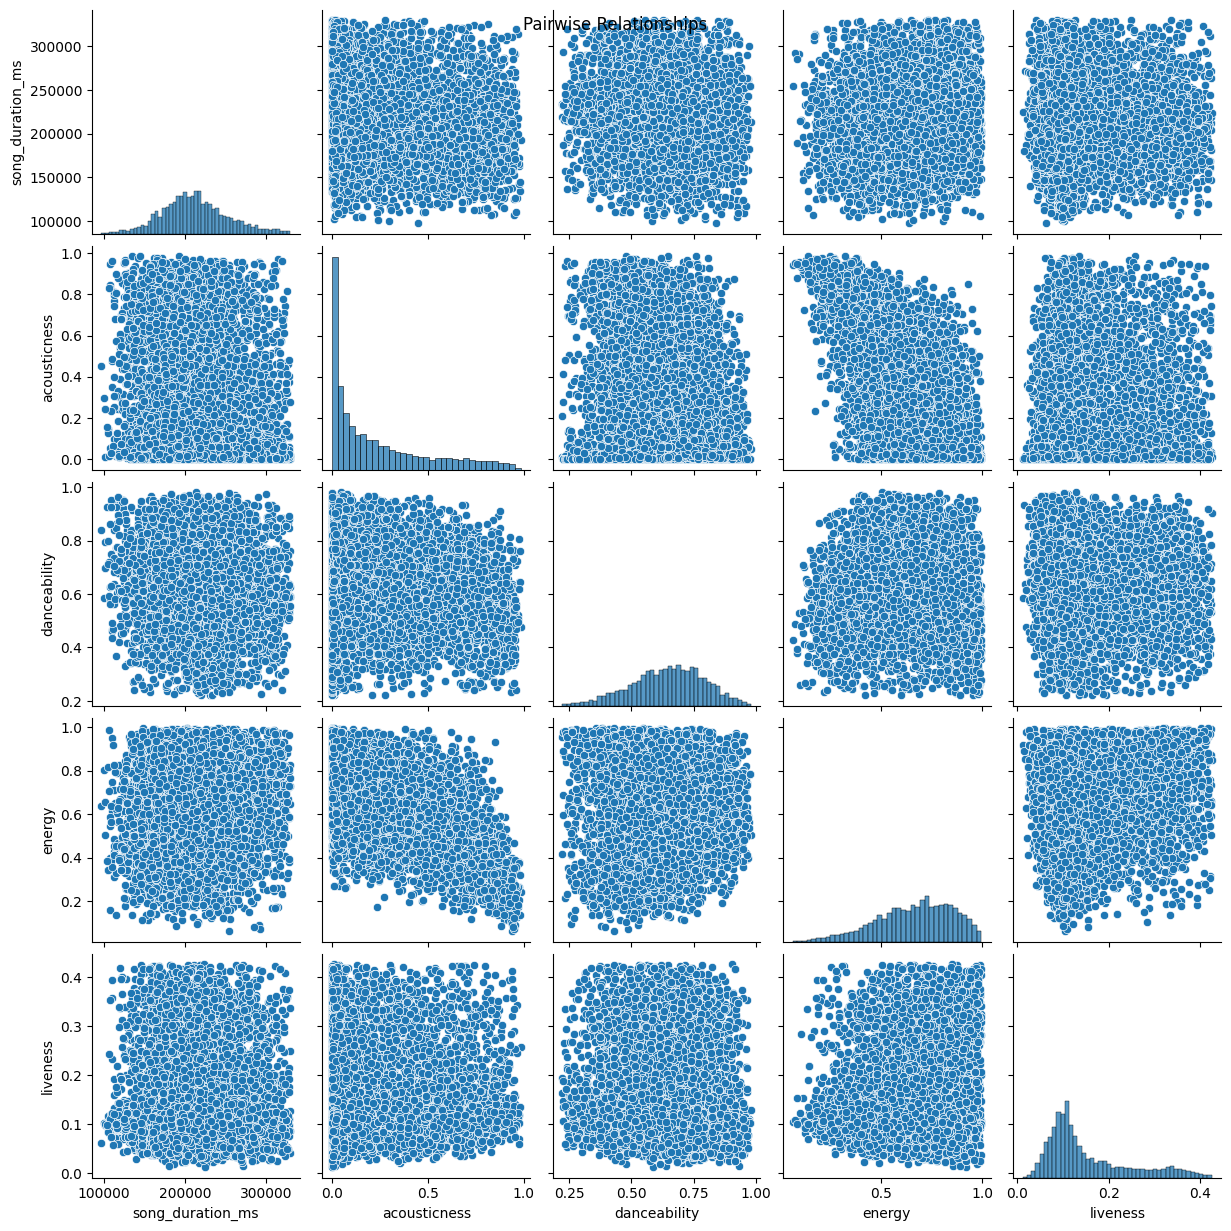

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.iloc[:, 1:].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Pair plots for selected features
sns.pairplot(df[numerical_features[:5]])  # adjust for relevant features
plt.suptitle("Pairwise Relationships")
plt.show()


In [105]:
from sklearn.preprocessing import StandardScaler

# Function to calculate VIF manually
def manual_variance_inflation_factor(X, i):
    # Add an intercept column of ones to simulate an intercept
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])

    # Separate the target feature (i-th column in original X)
    X_i = X_with_intercept[:, i + 1]  # Offset by 1 due to intercept column
    # Select all columns except the i-th one (and intercept) for predictors
    X_others = np.delete(X_with_intercept, i + 1, axis=1)

    # Fit a linear regression model to predict X_i using the other features
    model = LinearRegression()
    model.fit(X_others, X_i)

    # Calculate R-squared for this regression
    R_squared_i = model.score(X_others, X_i)

    # Calculate VIF using the formula
    if R_squared_i < 1:
        vif_i = 1 / (1 - R_squared_i)
    else:
        vif_i = np.inf  # Handle edge case of perfect multicollinearity

    return vif_i

# Standardize the data before calculating VIFs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_features])

# Calculate VIFs for each feature
vif_values = [manual_variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Create a DataFrame to store VIF results
vif_data = pd.DataFrame({
    "Feature": df[numerical_features].columns,
    "VIF": vif_values
})

print("Variance Inflation Factor (VIF):")
print(vif_data)

# Drop features with VIF > threshold (e.g., 10)
filtered_df = df.drop(columns=vif_data[vif_data["VIF"] > 10]["Feature"].tolist())


Variance Inflation Factor (VIF):
             Feature       VIF
0   song_duration_ms  1.038278
1       acousticness  1.756799
2       danceability  1.393510
3             energy  3.176372
4   instrumentalness  1.035343
5           liveness  1.032136
6           loudness  2.125989
7        speechiness  1.144074
8              tempo  1.052842
9      audio_valence  1.433850
10        song_sales  1.061262


In [107]:
# Prepare data
X = filtered_df.drop("song_sales", axis=1)
X = X.drop("song_name", axis=1).values
y = filtered_df["song_sales"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Measure runtime for scratch implementation
start_time = time.time()

# Linear Regression from Scratch
# Add the bias term (column of ones) to the training data
X_train_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # Adding bias to X_train
# Calculate theta_best using the closed-form solution
theta_best = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

# Prepare the test set by adding the bias term
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]  # Adding bias to X_test
# Predict the output for the test set
y_pred_scratch = X_test_b.dot(theta_best)

# Calculate Mean Squared Error (MSE) manually
mse_scratch = np.mean((y_test - y_pred_scratch) ** 2)

# Calculate runtime for scratch model
scratch_runtime = time.time() - start_time

# Measure runtime for scikit-learn implementation
start_time = time.time()

# Scikit-Learn Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_sklearn = lr.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

# Calculate runtime for sklearn model
sklearn_runtime = time.time() - start_time

print("MSE (Scratch):", mse_scratch)
print("MSE (Scikit-Learn):", mse_sklearn)
print("Runtime (Scratch):", scratch_runtime, "seconds")
print("Runtime (Scikit-Learn):", sklearn_runtime, "seconds")

MSE (Scratch): 102558263.87949556
MSE (Scikit-Learn): 102558263.87949538
Runtime (Scratch): 0.010399580001831055 seconds
Runtime (Scikit-Learn): 0.018603801727294922 seconds


In [29]:
# Ridge Regression
class ManualRidge:
    def __init__(self, alpha=1.0, learning_rate=0.001, iterations=1000):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.iterations = iterations

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y)) + (self.alpha * self.weights)
            db = (1 / self.m) * np.sum(y_pred - y)
            # Update weights with smaller learning rate
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Avoid NaNs by clipping very large weights
            self.weights = np.clip(self.weights, -1e10, 1e10)
            self.bias = np.clip(self.bias, -1e10, 1e10)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Lasso Regression
class ManualLasso:
    def __init__(self, alpha=1.0, learning_rate=0.001, iterations=1000):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.iterations = iterations

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y)) + (self.alpha * np.sign(self.weights))
            db = (1 / self.m) * np.sum(y_pred - y)
            # Update weights with smaller learning rate
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Avoid NaNs by clipping very large weights
            self.weights = np.clip(self.weights, -1e10, 1e10)
            self.bias = np.clip(self.bias, -1e10, 1e10)

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

In [30]:
alpha = 0.01

# Lasso Regression
lasso = ManualLasso(alpha=alpha, learning_rate=1e-13, iterations=850)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Ridge Regression
ridge = ManualRidge(alpha=alpha, learning_rate=1e-13, iterations=900)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("MSE (Lasso):", mse_lasso)
print("MSE (Ridge):", mse_ridge)


MSE (Lasso): 127357055.36738952
MSE (Ridge): 127363787.8219085


In [31]:
# Check training and test error
train_pred = lr.predict(X_train)
mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, y_pred_sklearn)

print("Training MSE:", mse_train)
print("Test MSE:", mse_test)
# If training MSE is much lower than test MSE, overfitting may be an issue.


Training MSE: 103851941.75657542
Test MSE: 102558263.87949538


In [109]:
# Categorize song sales
df['sales_category'] = pd.cut(df['song_sales'], bins=[0, 10000, 20000, 30000, 40000, 50000],
                              labels=["worst_seller", "low_seller", "medium_seller", "high_seller", "best_seller"])

print(df['sales_category'].value_counts())

# Step 1: Prepare the data
X = df.drop(["song_sales", "song_name", "sales_category"], axis=1)  # Drop target and non-numeric features
y = df['sales_category']  # Target is the sales category

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Step 4: Make predictions on the test data
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_scaled)

# Step 5: Evaluate the model performance
print(classification_report(y_test, y_pred))

# Step 6: Predict the sales category for all data points
all_predictions = model.predict(X_test_scaled)  # Predict the categories for the test data

# Add the predictions back into the DataFrame to check against the true values
df_test_results = pd.DataFrame({
    "True Sales Category": y_test,
    "Predicted Sales Category": all_predictions
})


sales_category
high_seller      3974
medium_seller    3752
low_seller       1532
best_seller      1059
worst_seller      895
Name: count, dtype: int64
               precision    recall  f1-score   support

  best_seller       0.07      0.01      0.02       195
  high_seller       0.38      0.66      0.48       780
   low_seller       0.33      0.00      0.01       333
medium_seller       0.39      0.44      0.41       760
 worst_seller       0.00      0.00      0.00       175

     accuracy                           0.38      2243
    macro avg       0.23      0.22      0.18      2243
 weighted avg       0.32      0.38      0.31      2243



In [33]:
# Evaluation metrics
mae_scratch = sum(abs(y_test[i] - y_pred_scratch[i]) for i in range(len(y_test))) / len(y_test)
r2 = r2_score(y_test, y_pred_sklearn)

print("Mean Absolute Error:", mae_scratch)
print("R-squared:", r2)


Mean Absolute Error: 8052.592566748818
R-squared: 0.046110256397623894


In [38]:
# Generate polynomial features (degree 2 for quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a linear regression model on polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions
y_pred_poly = model.predict(X_test_poly)

# Calculate Mean Squared Error
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("MSE with Polynomial Features (Degree 2):", mse_poly)


MSE with Polynomial Features (Degree 2): 102600169.57806185


In [43]:
# Standardize the features to mean=0 and variance=1, which is recommended before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA, selecting the number of components that capture most variance (e.g., 95%)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split the PCA-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a new linear regression model on the PCA-transformed data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)

print("R-squared with PCA:", r2)


R-squared with PCA: 0.04639956974652293


# Problem 3

In [44]:
# Load and preprocess the dataset
def load_and_preprocess_data(filename):
    # Load dataset
    data = pd.read_csv(filename).iloc[:, 1:]

    # Split into features and label
    X = data.drop(columns=['label'])
    y = data['label']

    # Split into training and test sets (90:10 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, y_train, y_test = load_and_preprocess_data('P3.csv')
X_train.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
17,-0.993256,-1.781313,0.521561,-0.896641,0.829735,0.530341,-1.393634,0.967867,0.021806,-2.179554,-0.628458,-0.422528,0.022528,0.427772,-1.578391
164,-0.077580,0.755212,0.273984,-0.348912,0.593681,1.247137,1.718754,0.288718,-0.049616,-0.505470,-1.689682,0.439825,-1.133570,-0.939479,0.526451
33,-0.924792,-1.517760,-0.408587,0.492055,-0.921886,-1.165090,-0.024049,-1.136327,-0.001310,0.586228,-0.581817,0.687661,0.389435,0.830061,0.212826
24,-0.276461,0.546217,-1.129716,1.702976,-2.106338,0.833429,0.412941,-0.271686,0.571730,1.687367,-0.517574,-0.141806,0.633684,0.502740,0.076833
215,-0.513626,3.112909,0.867305,-1.052340,1.946724,-0.017257,-0.350306,-0.043496,-0.285776,0.265682,-0.378394,-0.920415,0.260163,0.278015,-0.687048


In [46]:
def weighted_knn_loss(weights, X_train, y_train, k):
    # Calculate weighted distances for each point
    def weighted_distance(A, B, weights):
        return np.sqrt(np.sum(weights * (A - B)**2))

    # Get pairwise distances
    dist_matrix = pairwise_distances(X_train, metric=lambda A, B: weighted_distance(A, B, weights))

    # Predict labels for each observation based on k-nearest neighbors
    correct_predictions = 0
    for i, row in enumerate(dist_matrix):
        # Sort distances and get the indices of k nearest neighbors
        nearest_indices = np.argsort(row)[:k]
        nearest_labels = y_train.iloc[nearest_indices]

        # Majority voting
        prediction = nearest_labels.mode()[0]
        correct_predictions += (prediction == y_train.iloc[i])

    # Calculate accuracy as a loss metric (can adjust if needed)
    accuracy = correct_predictions / len(y_train)
    loss = 1 - accuracy  # Minimizing loss

    return loss


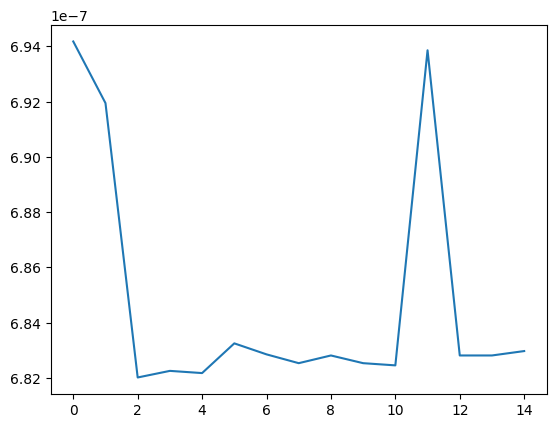

In [50]:
def optimize_weights(X_train, y_train, k):
    # Start with zero weights
    initial_weights = np.zeros(X_train.shape[1])

    # Define bounds to ensure weights are non-negative and capped if desired (e.g., max weight 10)
    bounds = [(0, 10) for _ in range(X_train.shape[1])]

    # Minimize the weighted_knn_loss function with constraints
    result = minimize(weighted_knn_loss, initial_weights, args=(X_train, y_train, k),
                      method='L-BFGS-B', bounds=bounds)
    optimized_weights = result.x
    return optimized_weights

# Optimize weights
k = 5
optimized_weights = optimize_weights(X_train, y_train, k)
plt.plot(optimized_weights)
plt.show()

In [53]:
def classify_with_knn(X_train, y_train, X_test, weights, k):
    # Predict labels for the test set based on the weighted KNN classifier
    def weighted_distance(A, B, weights):
        return np.sqrt(np.sum(weights * (A - B)**2))

    dist_matrix = pairwise_distances(X_test, X_train, metric=lambda A, B: weighted_distance(A, B, weights))

    y_pred = []
    for row in dist_matrix:
        nearest_indices = np.argsort(row)[:k]
        nearest_labels = y_train.iloc[nearest_indices]
        prediction = nearest_labels.mode()[0]
        y_pred.append(prediction)

    return y_pred

# Classification using weighted KNN
y_pred_weighted = classify_with_knn(X_train, y_train, X_test, optimized_weights, k)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)

# Classification using vanilla KNN (all weights set to 1)
y_pred_vanilla = classify_with_knn(X_train, y_train, X_test, np.ones(X_train.shape[1]), k)
accuracy_vanilla = accuracy_score(y_test, y_pred_vanilla)

print("Accuracy with Weighted KNN:", accuracy_weighted)
print("Accuracy with Vanilla KNN:", accuracy_vanilla)


Accuracy with Weighted KNN: 0.7666666666666667
Accuracy with Vanilla KNN: 0.7666666666666667


In [56]:
def random_feature_subsets(X_train, y_train, X_test, y_test, k, num_subsets=8, subset_size=5):
    results = {}
    for i in range(num_subsets):
        # Select a random subset of features
        selected_features = random.sample(list(X_train.columns), subset_size)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Classify with weighted KNN on this subset
        weights_subset = np.ones(len(selected_features))  # Equal weighting for vanilla KNN
        y_pred_subset = classify_with_knn(X_train_subset, y_train, X_test_subset, weights_subset, k)

        # Calculate and store accuracy
        accuracy = accuracy_score(y_test, y_pred_subset)
        results[f"Subset {i+1}"] = accuracy

    return results

# Test with random feature subsets
subset_accuracies = random_feature_subsets(X_train, y_train, X_test, y_test, k)
print("Random Subset Accuracies:", subset_accuracies)


Random Subset Accuracies: {'Subset 1': 0.5666666666666667, 'Subset 2': 0.43333333333333335, 'Subset 3': 0.7666666666666667, 'Subset 4': 0.8666666666666667, 'Subset 5': 0.6, 'Subset 6': 0.4666666666666667, 'Subset 7': 0.8333333333333334, 'Subset 8': 0.9}


In [57]:
def top_weighted_features(X_train, y_train, X_test, y_test, weights, k, num_features=5):
    # Get the indices of the top-weighted features
    top_indices = np.argsort(-weights)[:num_features]
    selected_features = X_train.columns[top_indices]

    # Subset the data
    X_train_top = X_train[selected_features]
    X_test_top = X_test[selected_features]

    # Classify with the top features
    weights_top = weights[top_indices]
    y_pred_top = classify_with_knn(X_train_top, y_train, X_test_top, weights_top, k)

    accuracy = accuracy_score(y_test, y_pred_top)
    return accuracy, selected_features

# Get classification results with top features
accuracy_top, top_features = top_weighted_features(X_train, y_train, X_test, y_test, optimized_weights, k)
print("Accuracy with Top Weighted Features:", accuracy_top)
print("Top Features:", top_features)


Accuracy with Top Weighted Features: 0.8
Top Features: Index(['f1', 'f12', 'f2', 'f6', 'f15'], dtype='object')
